# EOPFZARR Driver with Rasterio Integration

This notebook demonstrates how to use the EOPFZARR GDAL driver with rasterio to work with EOPF Zarr datasets.

## Overview

- **EOPFZARR Driver**: Custom GDAL driver for reading EOPF (Earth Observation Processing Framework) Zarr datasets
- **rasterio**: Pythonic interface to GDAL for reading and writing geospatial raster data
- **Integration**: Direct access to EOPF Zarr datasets with full geospatial metadata

## Key Features

✅ Open EOPF Zarr datasets with `rasterio.open()`   
✅ List and access subdatasets  
✅ Read geospatial metadata (CRS, transform, bounds)    
✅ Efficient windowed reading   
✅ NumPy array integration      
✅ Fast and lightweight (no eager subdataset loading like rioxarray)    

## Rasterio vs Rioxarray

**Rasterio**:
- ✅ Lightweight and fast
- ✅ Can open root datasets quickly (just lists subdatasets, doesn't open them)
- ✅ Direct GDAL interface
- ❌ No xarray integration

**Rioxarray** (see notebook 08):
- ✅ Full xarray integration
- ✅ Labeled dimensions and coordinates
- ✅ Advanced array operations
- ⚠️  Eagerly loads all subdatasets when opening root datasets

## 1. Setup and Imports

In [1]:
# Import required libraries
import rasterio
from rasterio.windows import Window
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import time

# Enable GDAL exceptions for better error messages
gdal.UseExceptions()

print("✅ Imports successful!")
print(f"rasterio version: {rasterio.__version__}")
print(f"GDAL version: {rasterio.__gdal_version__}")

✅ Imports successful!
rasterio version: 1.4.3
GDAL version: 3.11.1


## 2. Test Dataset

We'll use a Sentinel-3 OLCI Level-1 EFR dataset from EODC (European Open Data Cube).

**Note:** We use the `EOPFZARR:` driver prefix to ensure our custom driver handles the dataset.

In [2]:
# Define the test dataset URL
test_url = (
    "https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/"
    "19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_"
    "20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr"
)

# Construct the EOPFZARR dataset path
zarr_path = f'EOPFZARR:"/vsicurl/{test_url}"'

print(f"Dataset: {zarr_path}")

Dataset: EOPFZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr"


## 3. Open Root Dataset and List Subdatasets

Unlike rioxarray, rasterio can efficiently open root datasets to list subdatasets without loading them all.

In [3]:
# Open the root dataset
print("Opening root dataset...")
start_time = time.time()

with rasterio.open(zarr_path) as src:
    # Get subdatasets
    subdatasets = src.subdatasets
    
elapsed = time.time() - start_time

print(f"\n✅ Opened in {elapsed:.2f} seconds")
print(f"Total subdatasets: {len(subdatasets)}")
print("\nFirst 10 subdatasets:")
print("=" * 80)
for i, sub in enumerate(subdatasets[:10], 1):
    # Extract the subdataset path
    sub_path = sub.split('":/')[-1] if '":/' in sub else sub
    print(f"{i:2d}. {sub_path}")

Opening root dataset...

✅ Opened in 0.79 seconds
Total subdatasets: 123

First 10 subdatasets:
 1. EOPFZARR:/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr:/conditions/geometry/latitude
 2. EOPFZARR:/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr:/conditions/image/latitude
 3. EOPFZARR:/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr:/quality/orphans/latitude
 4. EOPFZARR:/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250

## 4. Open a Specific Subdataset

Let's open a measurement subdataset - OLCI Band 1 radiance (400nm).

In [5]:
# Define the subdataset path
subdataset = f'EOPFZARR:"/vsicurl/{test_url}":/measurements/oa01_radiance'

print(f"Opening: {subdataset}")
print("\nThis should be fast...")

# Open with rasterio
start_time = time.time()
src = rasterio.open(subdataset)
elapsed = time.time() - start_time

print(f"\n✅ Opened successfully in {elapsed:.2f} seconds!")
print(f"\nDataset type: {type(src)}")
print(f"Shape: ({src.height}, {src.width})")
print(f"Bands: {src.count}")

Opening: EOPFZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr":/measurements/oa01_radiance

This should be fast...

✅ Opened successfully in 0.18 seconds!

Dataset type: <class 'rasterio.io.DatasetReader'>
Shape: (4091, 4865)
Bands: 1


## 5. Inspect Dataset Metadata

Rasterio provides easy access to all geospatial metadata.

In [6]:
# Display comprehensive metadata
print("Dataset Metadata:")
print("=" * 80)
print(f"Driver: {src.driver}")
print(f"Width: {src.width} pixels")
print(f"Height: {src.height} pixels")
print(f"Bands: {src.count}")
print(f"Data type: {src.dtypes[0]}")
print(f"\nCRS: {src.crs}")
print(f"\nTransform:")
print(src.transform)
print(f"\nBounds:")
print(f"  Left:   {src.bounds.left:.4f}")
print(f"  Bottom: {src.bounds.bottom:.4f}")
print(f"  Right:  {src.bounds.right:.4f}")
print(f"  Top:    {src.bounds.top:.4f}")
print(f"\nResolution:")
print(f"  X: {src.res[0]:.6f}")
print(f"  Y: {src.res[1]:.6f}")
print(f"\nNodata value: {src.nodata}")
print("=" * 80)

Dataset Metadata:
Driver: EOPFZARR
Width: 4865 pixels
Height: 4091 pixels
Bands: 1
Data type: float32

CRS: EPSG:4326

Transform:
| 0.00, 0.00, 10.00|
| 0.00,-0.00, 45.00|
| 0.00, 0.00, 1.00|

Bounds:
  Left:   10.0000
  Bottom: 40.0000
  Right:  15.0000
  Top:    45.0000

Resolution:
  X: 0.001028
  Y: 0.001222

Nodata value: nan


## 6. Read Full Band Data

Read the entire band into a NumPy array.

In [7]:
# Read the full band
print("Reading full band data...")
start_time = time.time()

# Read band 1 (rasterio uses 1-based indexing)
data = src.read(1)

elapsed = time.time() - start_time

print(f"\n✅ Read in {elapsed:.2f} seconds")
print(f"\nArray shape: {data.shape}")
print(f"Data type: {data.dtype}")
print(f"Memory usage: {data.nbytes / 1024 / 1024:.2f} MB")
print(f"\nStatistics:")
print(f"  Min:  {np.nanmin(data):.4f}")
print(f"  Max:  {np.nanmax(data):.4f}")
print(f"  Mean: {np.nanmean(data):.4f}")
print(f"  Std:  {np.nanstd(data):.4f}")

Reading full band data...

✅ Read in 36.34 seconds

Array shape: (4091, 4865)
Data type: float32
Memory usage: 75.92 MB

Statistics:
  Min:  26.9562
  Max:  325.6561
  Mean: 58.2622
  Std:  16.8996

✅ Read in 36.34 seconds

Array shape: (4091, 4865)
Data type: float32
Memory usage: 75.92 MB

Statistics:
  Min:  26.9562
  Max:  325.6561
  Mean: 58.2622
  Std:  16.8996


## 7. Windowed Reading

One of rasterio's most powerful features is windowed reading - read only specific portions of the data.

In [8]:
# Define a window (row_offset, col_offset, height, width)
window = Window(2000, 1000, 500, 500)

print(f"Reading window: col={window.col_off}, row={window.row_off}, ")
print(f"                width={window.width}, height={window.height}")
print()

# Read only the windowed portion
start_time = time.time()
window_data = src.read(1, window=window)
elapsed = time.time() - start_time

print(f"✅ Window read in {elapsed:.4f} seconds")
print(f"\nWindow data shape: {window_data.shape}")
print(f"Memory usage: {window_data.nbytes / 1024:.2f} KB")
print(f"\nWindow statistics:")
print(f"  Min:  {np.nanmin(window_data):.4f}")
print(f"  Max:  {np.nanmax(window_data):.4f}")
print(f"  Mean: {np.nanmean(window_data):.4f}")

Reading window: col=2000, row=1000, 
                width=500, height=500

✅ Window read in 2.7519 seconds

Window data shape: (500, 500)
Memory usage: 976.56 KB

Window statistics:
  Min:  46.5087
  Max:  79.8733
  Mean: 53.5286
✅ Window read in 2.7519 seconds

Window data shape: (500, 500)
Memory usage: 976.56 KB

Window statistics:
  Min:  46.5087
  Max:  79.8733
  Mean: 53.5286


## 8. Visualize Data

Let's visualize a subset of the radiance data.

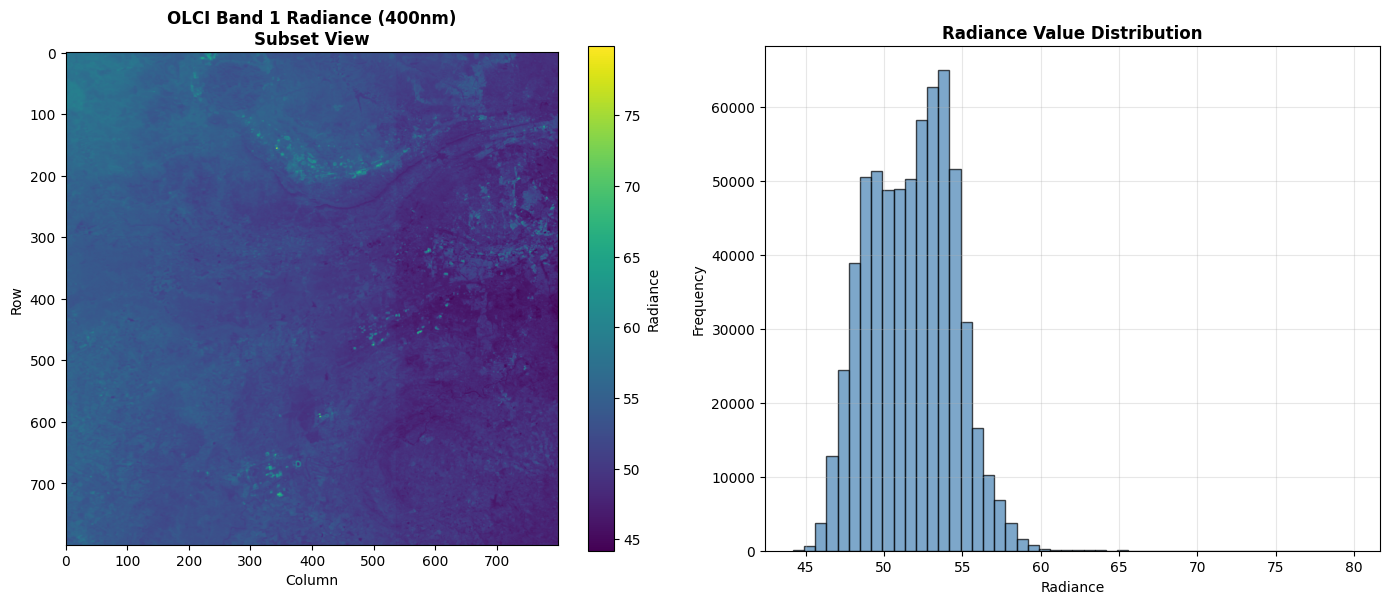

✅ Visualization complete!


In [9]:
# Read a visualization window
viz_window = Window(2000, 1000, 800, 800)
viz_data = src.read(1, window=viz_window)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Data
im1 = ax1.imshow(viz_data, cmap='viridis')
ax1.set_title('OLCI Band 1 Radiance (400nm)\nSubset View', fontsize=12, fontweight='bold')
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')
plt.colorbar(im1, ax=ax1, label='Radiance')

# Plot 2: Histogram
valid_data = viz_data[~np.isnan(viz_data)]
ax2.hist(valid_data.flatten(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax2.set_title('Radiance Value Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Radiance')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualization complete!")

## 9. Working with Multiple Subdatasets

Let's open and compare multiple OLCI bands.

In [11]:
# Define multiple bands to open
bands_to_open = [
    ('Band 1 (400nm - Violet)', '/measurements/oa01_radiance'),
    ('Band 6 (560nm - Green)', '/measurements/oa06_radiance'),
    ('Band 11 (709nm - Red Edge)', '/measurements/oa11_radiance'),
    ('Band 17 (865nm - NIR)', '/measurements/oa17_radiance')
]

print("Opening multiple bands...\n")
band_data = {}

for name, path in bands_to_open:
    subdataset_path = f'EOPFZARR:"/vsicurl/{test_url}":{path}'
    start = time.time()
    
    with rasterio.open(subdataset_path) as band_src:
        # Read a window for efficiency
        window = Window(2000, 1000, 500, 500)
        band_data[name] = band_src.read(1, window=window)
    
    elapsed = time.time() - start
    print(f"✅ {name}: {elapsed:.2f}s")

print("\nAll bands loaded successfully!")

Opening multiple bands...

✅ Band 1 (400nm - Violet): 2.66s
✅ Band 1 (400nm - Violet): 2.66s
✅ Band 6 (560nm - Green): 7.00s
✅ Band 6 (560nm - Green): 7.00s
✅ Band 11 (709nm - Red Edge): 7.87s
✅ Band 11 (709nm - Red Edge): 7.87s
✅ Band 17 (865nm - NIR): 8.22s

All bands loaded successfully!
✅ Band 17 (865nm - NIR): 8.22s

All bands loaded successfully!


In [12]:
# Compare statistics across bands
print("Band Statistics Comparison:")
print("=" * 90)
print(f"{'Band':<30} {'Min':>12} {'Max':>12} {'Mean':>12} {'Std':>12}")
print("=" * 90)

for name, data_array in band_data.items():
    min_val = np.nanmin(data_array)
    max_val = np.nanmax(data_array)
    mean_val = np.nanmean(data_array)
    std_val = np.nanstd(data_array)
    
    print(f"{name:<30} {min_val:>12.4f} {max_val:>12.4f} {mean_val:>12.4f} {std_val:>12.4f}")

print("=" * 90)

Band Statistics Comparison:
Band                                    Min          Max         Mean          Std
Band 1 (400nm - Violet)             46.5087      79.8733      53.5286       2.0241
Band 6 (560nm - Green)              21.0803     107.0879      40.8392       5.1108
Band 11 (709nm - Red Edge)           7.9597     103.9444      42.6044       7.2997
Band 17 (865nm - NIR)                2.6100     105.1401      42.8269       6.9229


## 10. Visualize Multiple Bands

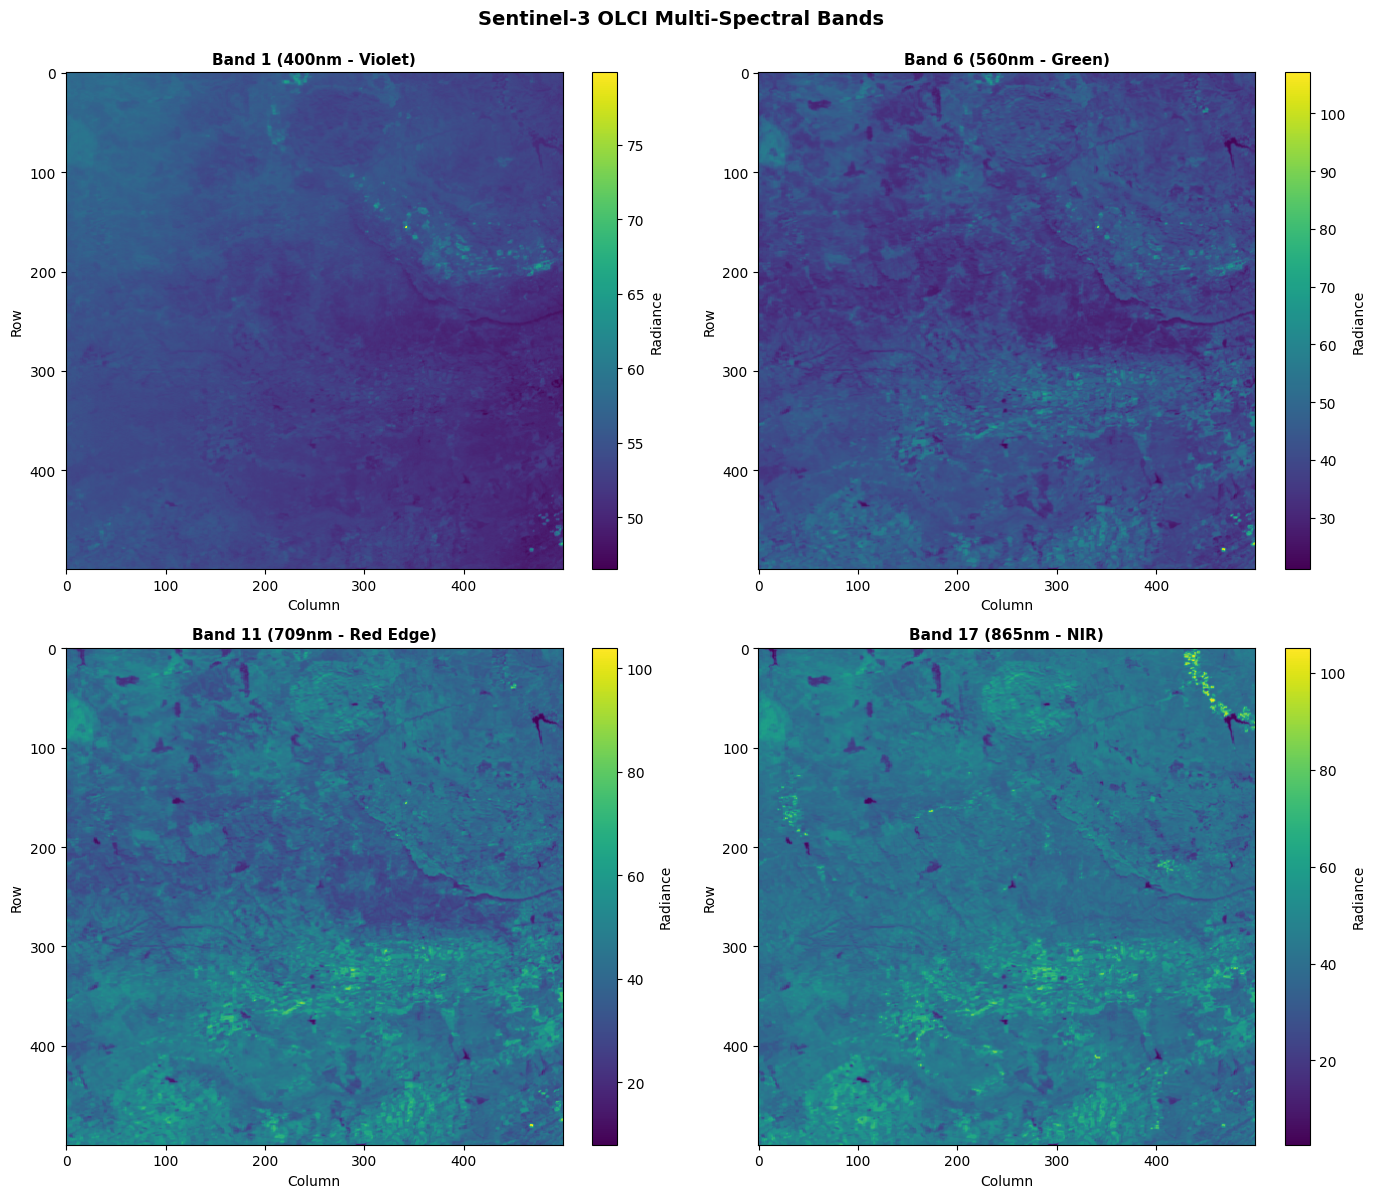

✅ Multi-band visualization complete!


In [13]:
# Create a 2x2 grid of band visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (name, data_array) in enumerate(band_data.items()):
    im = axes[idx].imshow(data_array, cmap='viridis')
    axes[idx].set_title(name, fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Column')
    axes[idx].set_ylabel('Row')
    plt.colorbar(im, ax=axes[idx], label='Radiance', fraction=0.046)

plt.suptitle('Sentinel-3 OLCI Multi-Spectral Bands', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✅ Multi-band visualization complete!")

## 11. Calculate Vegetation Index (NDVI-like)

Using the NIR (Band 17) and Red Edge (Band 11) to calculate a vegetation index.

Vegetation Index Calculation:
Index range: [-0.6277, 0.5685]
Mean: 0.0032
Std:  0.0514



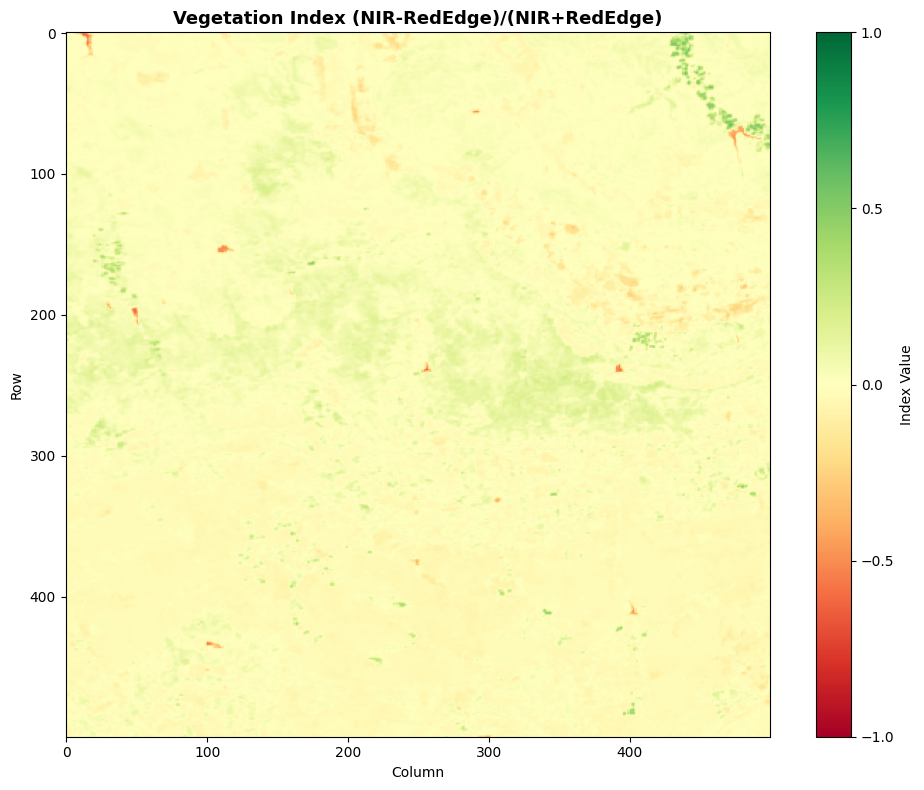

✅ Vegetation index calculated and visualized!


In [14]:
# Extract NIR and Red bands
nir = band_data['Band 17 (865nm - NIR)']
red = band_data['Band 11 (709nm - Red Edge)']

# Calculate normalized difference index
# NDVI-like = (NIR - Red) / (NIR + Red)
with np.errstate(divide='ignore', invalid='ignore'):
    ndvi = (nir - red) / (nir + red + 1e-8)
    ndvi[np.isnan(nir) | np.isnan(red)] = np.nan

print("Vegetation Index Calculation:")
print("=" * 50)
print(f"Index range: [{np.nanmin(ndvi):.4f}, {np.nanmax(ndvi):.4f}]")
print(f"Mean: {np.nanmean(ndvi):.4f}")
print(f"Std:  {np.nanstd(ndvi):.4f}")
print()

# Visualize the index
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
im = ax.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
ax.set_title('Vegetation Index (NIR-RedEdge)/(NIR+RedEdge)', fontsize=13, fontweight='bold')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
cbar = plt.colorbar(im, ax=ax, label='Index Value')
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
plt.tight_layout()
plt.show()

print("✅ Vegetation index calculated and visualized!")

## 12. Pixel Value Sampling

Extract pixel values at specific coordinates.

In [15]:
# Sample some pixel locations (row, col)
sample_points = [
    (100, 200),
    (250, 300),
    (400, 150)
]

print("Sampling pixel values at specific locations:")
print("=" * 80)
print(f"{'Location (row, col)':<25} {'Band 1':>12} {'Band 6':>12} {'Band 11':>12} {'Band 17':>12}")
print("=" * 80)

for row, col in sample_points:
    b1 = band_data['Band 1 (400nm - Violet)'][row, col]
    b6 = band_data['Band 6 (560nm - Green)'][row, col]
    b11 = band_data['Band 11 (709nm - Red Edge)'][row, col]
    b17 = band_data['Band 17 (865nm - NIR)'][row, col]
    
    print(f"({row:3d}, {col:3d})              {b1:>12.4f} {b6:>12.4f} {b11:>12.4f} {b17:>12.4f}")

print("=" * 80)

Sampling pixel values at specific locations:
Location (row, col)             Band 1       Band 6      Band 11      Band 17
(100, 200)                   55.6713      45.9751      46.7131      46.5506
(250, 300)                   51.6081      31.8513      30.2251      36.2437
(400, 150)                   52.2762      36.8203      44.1630      39.4048


## 13. Geographic Coordinate Conversion

Convert pixel coordinates to geographic coordinates using the affine transform.

In [17]:
# Reopen a subdataset to access its transform
subdataset_path = f'EOPFZARR:"/vsicurl/{test_url}":/measurements/oa01_radiance'

with rasterio.open(subdataset_path) as dataset:
    # Convert pixel coordinates to geographic coordinates
    print("Pixel to Geographic Coordinate Conversion:")
    print("=" * 80)
    print(f"{'Pixel (row, col)':<20} {'Geographic (lon, lat)':>30} {'CRS':>20}")
    print("=" * 80)
    
    for row, col in sample_points:
        # Convert to geographic coordinates
        lon, lat = dataset.xy(row, col)
        print(f"({row:3d}, {col:3d})           ({lon:>10.4f}, {lat:>10.4f})    {dataset.crs}")
    
    print("=" * 80)

Pixel to Geographic Coordinate Conversion:
Pixel (row, col)              Geographic (lon, lat)                  CRS
(100, 200)           (   10.2061,    44.8772)    EPSG:4326
(250, 300)           (   10.3088,    44.6938)    EPSG:4326
(400, 150)           (   10.1547,    44.5105)    EPSG:4326


## 14. Performance: Rasterio vs Rioxarray

Let's demonstrate why rasterio is faster for opening root datasets.

In [19]:
print("Performance Comparison: Opening Root Dataset")
print("=" * 80)

# Test 1: Rasterio (fast - just lists subdatasets)
print("\n1. Rasterio.open() - Root dataset:")
start = time.time()
with rasterio.open(zarr_path) as src:
    num_subdatasets = len(src.subdatasets)
rasterio_time = time.time() - start
print(f"   Time: {rasterio_time:.2f}s")
print(f"   Found {num_subdatasets} subdatasets")
print(f"   ✅ FAST: Just lists subdatasets, doesn't open them")

print("\n2. Rasterio.open() - Specific subdataset:")
start = time.time()
with rasterio.open(f'EOPFZARR:"/vsicurl/{test_url}":/measurements/oa01_radiance') as src:
    shape = (src.height, src.width)
specific_time = time.time() - start
print(f"   Time: {specific_time:.2f}s")
print(f"   Shape: {shape}")
print(f"   ✅ FAST: Direct access to specific data")

print("\n" + "=" * 80)
print("\nConclusion:")
print(f"  • Rasterio can open root datasets efficiently: {rasterio_time:.2f}s")
print(f"  • Opening specific subdatasets is also fast: {specific_time:.2f}s")
print(f"  • Rioxarray would take ~30+ seconds to open root (loads all {num_subdatasets} subdatasets!)")
print("\n  ✅ Use rasterio for dataset exploration and metadata inspection")
print("  ✅ Use rioxarray when you need xarray's labeled dimensions and operations")

Performance Comparison: Opening Root Dataset

1. Rasterio.open() - Root dataset:
   Time: 0.06s
   Found 123 subdatasets
   ✅ FAST: Just lists subdatasets, doesn't open them

2. Rasterio.open() - Specific subdataset:
   Time: 0.04s
   Shape: (4091, 4865)
   ✅ FAST: Direct access to specific data


Conclusion:
  • Rasterio can open root datasets efficiently: 0.06s
  • Opening specific subdatasets is also fast: 0.04s
  • Rioxarray would take ~30+ seconds to open root (loads all 123 subdatasets!)

  ✅ Use rasterio for dataset exploration and metadata inspection
  ✅ Use rioxarray when you need xarray's labeled dimensions and operations


## 15. Reading with Out-of-Core Computation

For very large datasets, read data in chunks to avoid memory issues.

In [21]:
# Open a subdataset
subdataset_path = f'EOPFZARR:"/vsicurl/{test_url}":/measurements/oa01_radiance'

with rasterio.open(subdataset_path) as src:
    # Calculate statistics without loading full array
    print("Computing statistics using chunked reading...")
    print()
    
    # Define chunk size
    chunk_size = 500
    
    # Initialize accumulators
    sum_val = 0
    sum_sq = 0
    count = 0
    min_val = float('inf')
    max_val = float('-inf')
    
    # Read in chunks
    num_chunks = 0
    for row in range(0, src.height, chunk_size):
        for col in range(0, src.width, chunk_size):
            # Define window
            window_height = min(chunk_size, src.height - row)
            window_width = min(chunk_size, src.width - col)
            window = Window(col, row, window_width, window_height)
            
            # Read chunk
            chunk = src.read(1, window=window)
            
            # Update statistics
            valid = chunk[~np.isnan(chunk)]
            if len(valid) > 0:
                sum_val += np.sum(valid)
                sum_sq += np.sum(valid ** 2)
                count += len(valid)
                min_val = min(min_val, np.min(valid))
                max_val = max(max_val, np.max(valid))
            
            num_chunks += 1
    
    # Compute final statistics
    mean = sum_val / count
    std = np.sqrt((sum_sq / count) - (mean ** 2))
    
    print(f"✅ Processed {num_chunks} chunks")
    print(f"   Chunk size: {chunk_size}x{chunk_size} pixels")
    print(f"   Valid pixels: {count:,}")
    print(f"\nStatistics (computed from chunks):")
    print(f"  Min:  {min_val:.4f}")
    print(f"  Max:  {max_val:.4f}")
    print(f"  Mean: {mean:.4f}")
    print(f"  Std:  {std:.4f}")

Computing statistics using chunked reading...

✅ Processed 90 chunks
   Chunk size: 500x500 pixels
   Valid pixels: 19,296,957

Statistics (computed from chunks):
  Min:  26.9562
  Max:  325.6561
  Mean: 58.2621
  Std:  16.8996
✅ Processed 90 chunks
   Chunk size: 500x500 pixels
   Valid pixels: 19,296,957

Statistics (computed from chunks):
  Min:  26.9562
  Max:  325.6561
  Mean: 58.2621
  Std:  16.8996


## 16. Clean Up

Close any open datasets.

In [22]:
# Close the dataset if it's still open
if 'src' in locals() and not src.closed:
    src.close()
    print("✅ Dataset closed")
else:
    print("✅ All datasets already closed")

✅ All datasets already closed


## 17. Summary

This notebook demonstrated:

1. ✅ Opening EOPF Zarr datasets with rasterio
2. ✅ Efficiently listing subdatasets without loading them
3. ✅ Accessing geospatial metadata (CRS, transform, bounds, resolution)
4. ✅ Full band and windowed data reading
5. ✅ Multi-band analysis and visualization
6. ✅ Vegetation index calculation
7. ✅ Pixel sampling and coordinate conversion
8. ✅ Performance comparison with rioxarray
9. ✅ Chunked/out-of-core computation for large datasets

## Key Takeaways

**When to use Rasterio:**
- ✅ Fast dataset exploration and metadata inspection
- ✅ Working with root datasets (listing subdatasets)
- ✅ Windowed/chunked reading for large datasets
- ✅ Simple NumPy array operations
- ✅ Direct GDAL interface needed

**When to use Rioxarray (see notebook 08):**
- ✅ Need xarray's labeled dimensions
- ✅ Complex multi-dimensional operations
- ✅ Integration with xarray ecosystem
- ✅ Working with specific subdatasets only

## Resources

- [Rasterio Documentation](https://rasterio.readthedocs.io/)
- [GDAL Documentation](https://gdal.org/)
- [EOPFZARR GitHub](https://github.com/EOPF-Sample-Service/GDAL-ZARR-EOPF)
- [Notebook 08: EOPFZARR with Rioxarray](08-EOPFZARR-with-Rioxarray.ipynb)